<a href="https://colab.research.google.com/github/cenzwong/MSBD5012/blob/main/MSBD5012_river.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# River Implementation

In [25]:
!pip install git+https://github.com/online-ml/river --upgrade
!pip install -U numpy

  Cloning https://github.com/online-ml/river to /tmp/pip-req-build-eshgwfvm
  Running command git clone -q https://github.com/online-ml/river /tmp/pip-req-build-eshgwfvm


In [26]:
# !gdown https://drive.google.com/uc?id=1LHDaW3vqUBcA7yPUh3CiV5muJn7d0EFD
!wget https://raw.githubusercontent.com/cenzwong/MSBD5012/main/data/train.csv.zip -O train.csv.zip
!unzip train.csv.zip

--2021-11-26 14:48:04--  https://raw.githubusercontent.com/cenzwong/MSBD5012/main/data/train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23570978 (22M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zip       100%[===================>]  22.48M   146MB/s    in 0.2s    

2021-11-26 14:48:05 (146 MB/s) - ‘train.csv.zip’ saved [23570978/23570978]

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [27]:
import numpy as np
import pandas as pd

df_csv = pd.read_csv('./train.csv', usecols=['id', 'date', 'family', 'sales'], header=0)

data = df_csv.copy()
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")
df_train_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2014-01-01') & (data['date'] <= '2017-06-30'))].groupby(['date']).sum().copy()
df_train_mag_sales = df_train_mag_sales.loc[:, 'sales':'sales']

data = df_csv.copy()
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")
df_test_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2017-07-1') & (data['date'] <= '2017-08-15'))].groupby(['date']).sum().copy()
df_test_mag_sales = df_test_mag_sales.loc[:, 'sales':'sales']


In [28]:
# from river import stream

# rv_train = stream.iter_csv(
#     '/content/train.csv',
#     converters={
#         'sales':float
#     },
#     drop = ['id', 'family', 'onpromotion', 'store_nbr'],
#     parse_dates={'date': '%Y-%m-%d'},
#     target='sales'
# )

# for x, y in rv_train:
#     print(x, y)
#     break

In [29]:
df_train_mag_sales.head(2)
df_train_mag_sales.to_csv('train_clean.csv', index=True)

In [30]:
params = {
  'converters': {'sales': float},
  'parse_dates': {'date': '%Y-%m-%d'} 
  }
next(stream.iter_csv('train_clean.csv', target='sales', **params))

({'date': datetime.datetime(2014, 1, 1, 0, 0)}, 1.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


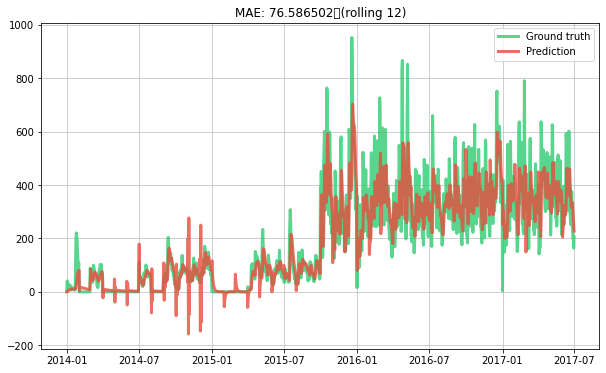

In [49]:
from river import compose
from river import linear_model
from river import preprocessing
from river import time_series


def get_ordinal_date(x):
    return {'ordinal_date': x['date'].toordinal()}

def get_month(x):
    return {
        calendar.month_name[month]: month == x['date'].month
        for month in range(1, 13)
    }




In [52]:
from river import metrics
import matplotlib.pyplot as plt

import calendar




def evaluate_model(model, rolling): 

    metric = metrics.Rolling(metrics.MAE(), rolling)

    dates = []
    y_trues = []
    y_preds = []

    params = {
     'converters': {'sales': float},
     'parse_dates': {'date': '%Y-%m-%d'} 
     }
    for x, y in stream.iter_csv('train_clean.csv', target='sales', **params):

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x['date'])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


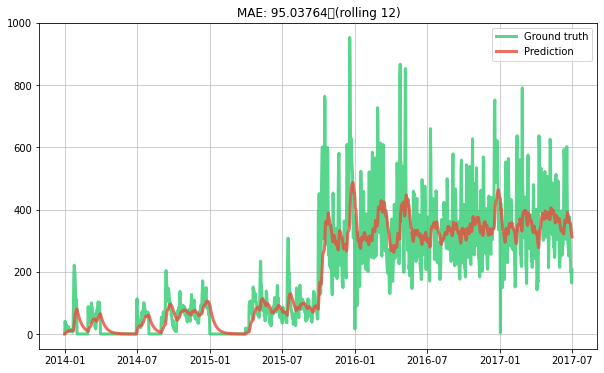

In [53]:
model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

evaluate_model(model, 12)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


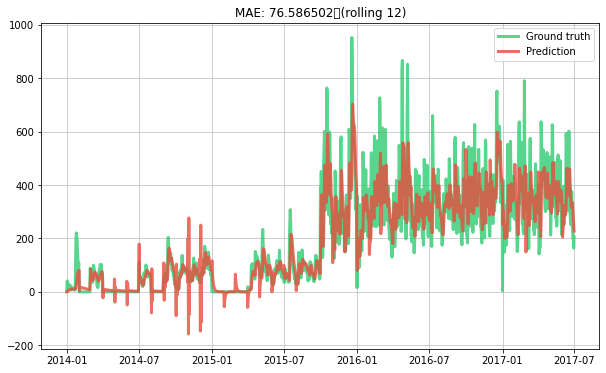

In [54]:
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

evaluate_model(model, 12)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


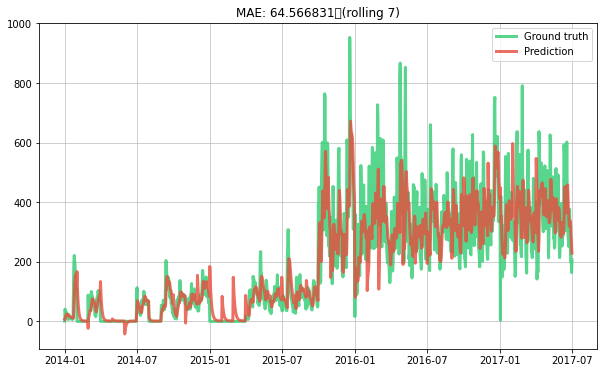

In [58]:
evaluate_model(model, 7)

In [60]:
model['lin_reg'].weights

{'April': 34.35583909559287,
 'August': -3.262102103172545,
 'December': 22.580786860688477,
 'February': 43.63059073087111,
 'January': 6.985094484702804,
 'July': 1.997466105664945,
 'June': -15.115371923186053,
 'March': -4.388749387756113,
 'May': 1.4406045157129679,
 'November': -14.78060460913136,
 'October': 11.178414479457864,
 'September': -3.8385449351216914,
 'ordinal_date': 83.10309401411568}

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


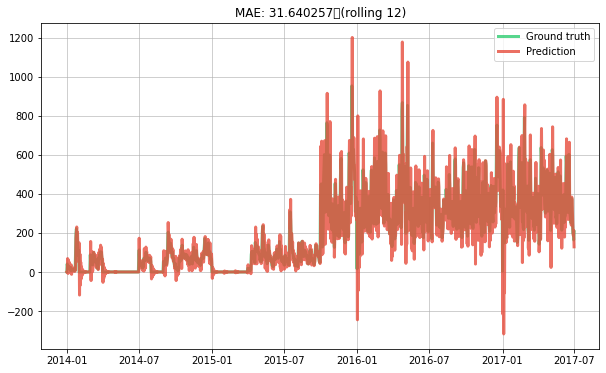

In [147]:
from river import optim
import math

def get_month_distances(x):
  return {
      calendar.month_name[month]: math.exp((-(x['date'].month - month) ** 2)/(2*(0.015)**2)) for month in range(1, 13)
      
  }

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month_distances)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(
                intercept_lr=0.85,
        optimizer=optim.SGD(0.001)
    ))
)

evaluate_model(model, 12)